In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
df = pd.read_csv("Datasets/gld_price_data.csv")
df.head()

,Date,SPX,GLD,USO,SLV,EUR/USD
0,1/2/2008,1447.160034,84.860001,78.470001,15.180,1.471692
1,1/3/2008,1447.160034,85.570000,78.370003,15.285,1.474491
2,1/4/2008,1411.630005,85.129997,77.309998,15.167,1.475492
3,1/7/2008,1416.180054,84.769997,75.500000,15.053,1.468299
4,1/8/2008,1390.189941,86.779999,76.059998,15.590,1.557099


In [4]:
df.tail()

,Date,SPX,GLD,USO,SLV,EUR/USD
2285,5/8/2018,2671.919922,124.589996,14.0600,15.5100,1.186789
2286,5/9/2018,2697.790039,124.330002,14.3700,15.5300,1.184722
2287,5/10/2018,2723.070068,125.180000,14.4100,15.7400,1.191753
2288,5/14/2018,2730.129883,124.489998,14.3800,15.5600,1.193118
2289,5/16/2018,2725.780029,122.543800,14.4058,15.4542,1.182033


In [5]:
df.isnull().sum()

Date       0
SPX        0
GLD        0
USO        0
SLV        0
EUR/USD    0
dtype: int64

In [7]:
df.describe()

,SPX,GLD,USO,SLV,EUR/USD
count,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000
mean,1654.315776,122.732875,31.842221,20.084997,1.283653
std,519.111540,23.283346,19.523517,7.092566,0.131547
min,676.530029,70.000000,7.960000,8.850000,1.039047
25%,1239.874969,109.725000,14.380000,15.570000,1.171313
50%,1551.434998,120.580002,33.869999,17.268500,1.303297
75%,2073.010070,132.840004,37.827501,22.882500,1.369971
max,2872.870117,184.589996,117.480003,47.259998,1.598798


In [9]:
corr = df.corr()

<AxesSubplot:>

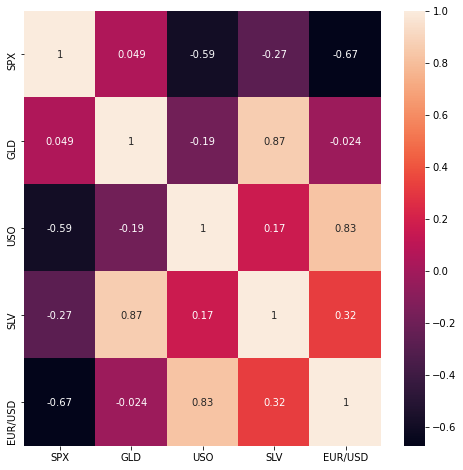

In [21]:
plt.figure(figsize = (8,8))
sns.heatmap(corr, annot=True)

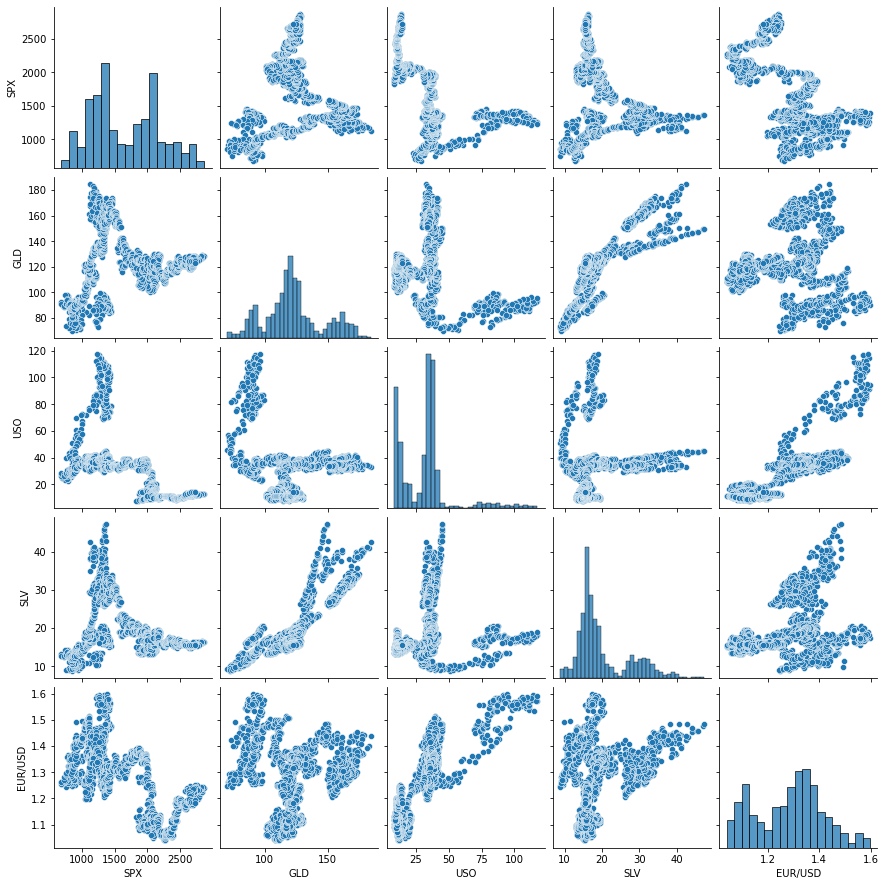

In [22]:
sns.pairplot(df)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='GLD', ylabel='Density'>

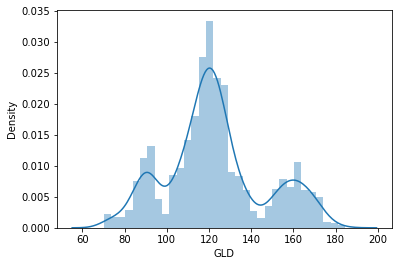

In [23]:
sns.distplot(df['GLD'])

In [25]:
df.shape

(2290, 6)

In [27]:
X = df.drop(['Date', 'GLD'], axis='columns')
y = df.GLD

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [102]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

#### model selection

In [103]:
def best_model(X,y):
    algos = {
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['mse', 'friedman_mse'],
                'splitter': ['best', 'random']
            }
        },
        'RandomForestRegressor': {
            'model': RandomForestRegressor(),
            'params': {
                'n_estimators': [10, 50, 100, 130],
                'criterion': ['mse'],
                'max_depth': range(2, 4, 1),
                'max_features': ['auto', 'log2']
            }
        },
        'XGBRegressor': {
            'model': XGBRegressor(),
            'params': {
                'learning_rate': [0.5, 0.1, 0.01, 0.001],
                'max_depth': [2, 3],
                'n_estimators': [10, 50, 100, 130]
            }
        }
    }
    
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

In [114]:
pd.set_option("display.max_colwidth", 100)
best_model(X,y)

,model,best_score,best_params
0,decision_tree,0.981827,"{'criterion': 'mse', 'splitter': 'best'}"
1,RandomForestRegressor,0.911152,"{'criterion': 'mse', 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 50}"
2,XGBRegressor,0.984343,"{'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 130}"


In [115]:
model = XGBRegressor(learning_rate=0.5, max_depth= 3, n_estimators= 130)

In [116]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.5, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=130, n_jobs=2, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [117]:
model.score(X_test, y_test)

0.9822652456266316

In [122]:
import pickle
pickle.dump(model,open('GoldPriceXGBoost.pkl', 'wb'))

In [125]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1717 entries, 2036 to 66
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SPX      1717 non-null   float64
 1   USO      1717 non-null   float64
 2   SLV      1717 non-null   float64
 3   EUR/USD  1717 non-null   float64
dtypes: float64(4)
memory usage: 67.1 KB


In [130]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 573 entries, 86 to 366
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SPX      573 non-null    float64
 1   USO      573 non-null    float64
 2   SLV      573 non-null    float64
 3   EUR/USD  573 non-null    float64
dtypes: float64(4)
memory usage: 22.4 KB


In [131]:
X_test.head()

,SPX,USO,SLV,EUR/USD
86,1426.630005,102.800003,16.819000,1.565411
330,940.739990,33.560001,13.090000,1.410497
903,1351.949951,38.330002,32.900002,1.324854
650,1257.540039,38.709999,28.590000,1.307976
1659,2099.600098,17.510000,14.810000,1.099046


In [153]:
pre = model.predict(X_test)
pre

array([ 90.095245,  89.79983 , 169.53246 , 147.93935 , 110.270454,
       111.497   , 126.05328 , 157.97952 , 151.83098 , 126.56363 ,
       122.063965, 168.60709 , 102.878334, 136.06224 , 161.4469  ,
       121.48008 , 155.20665 , 152.64055 , 120.25109 , 128.32576 ,
       135.83372 , 114.38554 , 125.44377 , 155.855   , 114.55815 ,
       129.95975 , 173.63432 , 123.11922 , 107.3634  , 149.57405 ,
        94.26843 , 126.61586 , 121.58278 ,  88.3264  , 124.841064,
       119.9698  , 160.10652 , 135.78593 , 113.59642 ,  98.90098 ,
       114.996376, 166.88586 , 176.65865 , 146.45644 , 107.46023 ,
       130.8416  , 119.851906, 127.08789 , 117.868126, 155.56442 ,
       178.9883  , 103.790695, 111.34327 , 172.7457  , 104.69559 ,
       167.4732  , 114.59521 ,  84.50755 , 125.26217 , 158.35832 ,
       126.824974, 105.86325 , 109.126114, 130.17824 , 150.39442 ,
        93.2835  ,  86.103874, 113.11012 , 160.87126 , 155.6268  ,
        89.81264 ,  85.024155, 119.13798 ,  90.33059 , 109.576

In [154]:
inp = [1426.630005,102.800003,16.819000,1.565411]


In [166]:
model2 = DecisionTreeRegressor(criterion='mse', splitter='best')

In [167]:
model2.fit(X_train, y_train)

DecisionTreeRegressor()

In [168]:
model2.score(X_test, y_test)

0.9714568792533592

In [170]:
X_test.head()

,SPX,USO,SLV,EUR/USD
86,1426.630005,102.800003,16.819000,1.565411
330,940.739990,33.560001,13.090000,1.410497
903,1351.949951,38.330002,32.900002,1.324854
650,1257.540039,38.709999,28.590000,1.307976
1659,2099.600098,17.510000,14.810000,1.099046


In [171]:
model2.predict([[1426.630005, 102.800003, 16.819000, 1.565411]])

array([86.449997])

In [172]:
model2.predict(X_test)

array([ 86.449997,  91.199997, 168.970001, 157.160004, 111.360001,
       112.580002, 125.389999, 161.509995, 156.080002, 128.889999,
       122.790001, 167.289993, 104.040001, 138.369995, 162.300003,
       123.32    , 154.669998, 151.440002, 119.330002, 129.470001,
       133.509995, 113.849998, 123.610001, 160.380005, 115.839996,
       132.210007, 167.339996, 124.860001, 107.949997, 161.490005,
        93.059998, 117.120003, 119.309998,  91.610001, 123.650002,
       122.959999, 154.5     , 133.690002, 114.870003,  98.709999,
       116.849998, 169.419998, 169.050003, 135.380005, 107.589996,
       132.210007, 120.139999, 126.989998, 117.650002, 153.380005,
       177.669998, 111.019997, 109.300003, 167.179993, 105.120003,
       165.649994, 113.849998,  86.519997, 127.779999, 167.100006,
       126.470001, 104.209999, 109.129997, 130.279999, 150.410004,
        92.559998,  86.709999, 114.32    , 160.440002, 153.050003,
        91.610001,  82.18    , 119.290001,  90.190002, 107.75 

In [173]:
import pickle
pickle.dump(model,open('GoldPriceDecisionTree.pkl', 'wb'))